<a href="https://colab.research.google.com/github/SumeetChougule/PM-HR/blob/main/notebooks/Force_correction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Git clone

In [ ]:
!git clone https://github.com/DifferentiableUniverseInitiative/flowpm.git
!pip install git+https://github.com/DifferentiableUniverseInitiative/flowpm.git

Cloning into 'flowpm'...
remote: Enumerating objects: 3470, done.
remote: Counting objects: 100% (1315/1315), done.
remote: Compressing objects: 100% (464/464), done.
remote: Total 3470 (delta 855), reused 1228 (delta 831), pack-reused 2155
Receiving objects: 100% (3470/3470), 65.55 MiB | 24.94 MiB/s, done.
Resolving deltas: 100% (2284/2284), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/DifferentiableUniverseInitiative/flowpm.git to /tmp/pip-req-build-ww2y0v6f
  Running command git clone -q https://github.com/DifferentiableUniverseInitiative/flowpm.git /tmp/pip-req-build-ww2y0v6f
     |████████████████████████████████| 385 kB 4.9 MB/s 
     |████████████████████████████████| 221 kB 70.0 MB/s 
     |████████████████████████████████| 1.1 MB 59.0 MB/s 
  Created wheel for flowpm: filename=flowpm-0.1.2.dev252+g8f9415b-py3-none-any.whl size=45196 sha256=ba8c3bdb63199099b5d86fcf7c46ee3ba80bbbdbf7f16f0db2

## Modules

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras.layers as tfl
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
from tensorflow.keras import datasets, layers, models, losses

import tensorflow_probability as tfp
tfd = tfp.distributions

import flowpm
from astropy.cosmology import Planck15
from flowpm import linear_field, lpt_init, nbody, cic_paint, cic_readout
from flowpm.utils import r2c3d, c2r3d

from scipy.interpolate import InterpolatedUnivariateSpline as iuspline

import pandas as pd

## Input data from PM


In [ ]:
bs, nc = 100, 32
nsteps = 5
a0, af, nsteps = 0.1, 1.0,  nsteps
stages = np.linspace(a0, af, nsteps, endpoint=True)
donbody = False
dnoise = 1. #0.1

klin, plin = np.loadtxt('flowpm/flowpm/data/Planck15_a1p00.txt').T
ipklin = iuspline(klin, plin)

In [ ]:
@tf.function
def pm(linear):
    print("PM graph")
    cosmo = flowpm.cosmology.Planck15()
    state = lpt_init(cosmo, linear, a=a0, order=2)
    final_state = nbody(cosmo, state,  stages, nc)
    tfinal_field = cic_paint(tf.zeros_like(linear), final_state[0])
    return final_state, tfinal_field

ic = linear_field(nc, bs, ipklin, name='pm').numpy()
state, fin = pm(tf.constant(ic))
pos = state[0].numpy()


PM graph


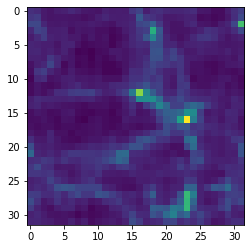

In [ ]:
plt.imshow(fin[0].numpy().sum(axis=0))

### Helper functions

In [ ]:
def cic_readout_features(mesh, part, name="CiCReadout"):
  """
  Reads out particles from mesh.
  Parameters: 
  ----------- 
  mesh: tensor (batch_size, nc, nc, nc, T)
      Input 4D mesh tensor with last axis of T features
  
  part: tensor (batch_size, npart, 3)
      List of 3D particle coordinates, assumed to be in mesh units if
  boxsize is None
  
  Return:
  -------
  value: tensor (batch_size, npart) 
      Value of the field sampled at the particle locations
  """
  with tf.name_scope("CiCReadoutFeatures"):
    mesh = tf.convert_to_tensor(mesh, name="mesh")
    part = tf.convert_to_tensor(part, name="part")

    shape = tf.shape(mesh)
    batch_size, nx, ny, nz = shape[0], shape[1], shape[2], shape[3]
    nc = [nx, ny, nz]

    # Flatten part if it's not already done                                                                                                                                                                                                                                                                                   
    if len(part.shape) > 3:
      part = tf.reshape(part, (batch_size, -1, 3))

    # Extract the indices of all the mesh points affected by each particles                                                                                                                                                                                                                                                   
    part = tf.expand_dims(part, 2)
    floor = tf.floor(part)
    connection = tf.expand_dims(
        tf.constant([[[0, 0, 0], [1., 0, 0], [0., 1, 0], [0., 0, 1],
                      [1., 1, 0], [1., 0, 1], [0., 1, 1], [1., 1, 1]]]), 0)

    neighboor_coords = tf.add(floor, connection)
    kernel = 1. - tf.abs(part - neighboor_coords)
    kernel = kernel[..., 0] * kernel[..., 1] * kernel[..., 2]

    neighboor_coords = tf.cast(neighboor_coords, tf.int32)
    neighboor_coords = tf.math.mod(neighboor_coords, nc)

    meshvals = tf.gather_nd(mesh, neighboor_coords, batch_dims=1)
    weightedvals = tf.multiply(meshvals, tf.expand_dims(kernel, -1))
    value = tf.reduce_sum(weightedvals, axis=-2)
    return value

def fftk(shape, symmetric=True, finite=False, dtype=np.float64):
    """ Return k_vector given a shape (nc, nc, nc) and box_size                                                                                                                                                                                                                                                                 
    """
    k = []
    for d in range(len(shape)):
        kd = np.fft.fftfreq(shape[d])
        kd *= 2 * np.pi
        kdshape = np.ones(len(shape), dtype='int')
        if symmetric and d == len(shape) - 1:
            kd = kd[:shape[d] // 2 + 1]
        kdshape[d] = len(kd)
        kd = kd.reshape(kdshape)

        k.append(kd.astype(dtype))
    del kd, kdshape
    return k


def laplace_kernel(kvec):
    kk = sum(ki**2 for ki in kvec)
    mask = (kk == 0).nonzero()
    kk[mask] = 1
    wts = 1. / kk
    imask = (~(kk == 0)).astype(int)
    wts *= imask
    return wts
 
 
def gradient_kernel(kvec, direction, order=1):
    print(direction)
    wts = 1j * kvec[direction]
    wts = np.squeeze(wts)
    wts[len(wts) // 2] = 0
    wts = wts.reshape(kvec[direction].shape)
    return wts
  

def force(delta_k, x, factor=1):
    

    shape = delta_k.get_shape()
    nc = shape[1:]

    kvec = fftk(nc, symmetric=False)

    ndim = 3
    norm = nc[0] * nc[1] * nc[2]
    lap = tf.cast(laplace_kernel(kvec), tf.complex64)
    pot_k = tf.multiply(delta_k, lap)

    f = []
    for d in range(ndim):
        force_dc = tf.multiply(pot_k, gradient_kernel(kvec, d))
        forced = c2r3d(force_dc, norm=norm)
        force = cic_readout(forced, x)
        f.append(force)

    f = tf.stack(f, axis=2)
    f = tf.multiply(f, factor)
    return f



## Data

In [ ]:
B = 2
ncb = B*nc
print(ncb)
posb = pos*ncb/nc #convert to grid position of new mesh

mesh = tf.zeros([1, nc, nc, nc])
meshb = tf.zeros([1, ncb, ncb, ncb])

mesh = cic_paint(mesh, pos)
meshb = cic_paint(meshb, posb)

f = force(r2c3d(mesh), pos)[0]
fb = force(r2c3d(meshb), posb)[0]


64
0
1
2
0
1
2


In [ ]:
f-fb

<tf.Tensor: shape=(32768, 3), dtype=float32, numpy=
array([[-0.76309526, -0.6797457 ,  1.0688927 ],
       [-0.86478245, -0.6206584 ,  0.9183786 ],
       [-0.8716813 , -0.54311836,  0.72548544],
       ...,
       [-0.5950794 , -1.542714  ,  1.2395549 ],
       [-0.5406352 , -1.4455705 ,  1.1589814 ],
       [-0.47308436, -1.2187994 ,  1.3276839 ]], dtype=float32)>

In [ ]:
f-fb

<tf.Tensor: shape=(32768, 3), dtype=float32, numpy=
array([[-1.8600725 , -1.170727  ,  0.92336935],
       [-2.0343995 , -1.3540828 ,  0.8604572 ],
       [-1.6967306 , -2.0074663 ,  0.14644316],
       ...,
       [-2.838324  , -0.6812401 , -0.41658807],
       [-2.5678413 , -0.87642026, -0.09485602],
       [-1.7008783 , -1.0793083 ,  0.71030766]], dtype=float32)>

In [ ]:
f

<tf.Tensor: shape=(32768, 3), dtype=float32, numpy=
array([[-2.7318504 ,  2.0853257 ,  3.871943  ],
       [ 2.5451562 ,  0.5408219 , -4.225219  ],
       [ 0.49211144,  0.2078676 , -4.2519045 ],
       ...,
       [-0.17287427,  0.89550316,  1.9564792 ],
       [-1.5365229 ,  1.3333457 ,  2.9090033 ],
       [-1.8431264 ,  2.184681  ,  3.0387163 ]], dtype=float32)>

In [ ]:
f_diff = f-fb
f_diff

<tf.Tensor: shape=(32768, 3), dtype=float32, numpy=
array([[-0.26307982,  0.34410954, -0.12277344],
       [-0.21068516,  0.4502238 , -0.9246173 ],
       [-0.14910404, -0.8153504 , -0.9148426 ],
       ...,
       [-0.68775344, -1.1752266 , -0.58556336],
       [-0.73817056, -1.1042435 , -0.6296613 ],
       [-0.9380119 , -1.0397513 , -0.81829214]], dtype=float32)>

In [ ]:
y= f_diff

In [ ]:
f_diff.shape

TensorShape([32768, 3])

TensorShape([32768, 3])

### Input

In [ ]:
ip_m = tf.expand_dims(fin,-1)
#in_pad = np.pad(ip_m)
ip = ip_m.shape
ip[1:]

TensorShape([32, 32, 32, 1])

In [ ]:
ip_np = ip_m.numpy()
ip_np.shape

(1, 32, 32, 32, 1)

In [167]:
# with wrap
in_pad = np.pad(ip_np, ((0,0),(3,3),(3,3),(3,3),(3,3)), mode='wrap')
in_wm = tf.convert_to_tensor(in_pad) 
in_wm.shape

TensorShape([1, 38, 38, 38, 7])

In [168]:
#With wrap
ip_w = in_wm.shape
ip_w[1:]

TensorShape([38, 38, 38, 7])

## Model

In [181]:
  input_data = tf.keras.Input(shape = ip_w[1:])
  print("Shape of input:", input_data.shape)
  cnn1   = tfl.Conv3D(filters = 8, kernel_size= 3, strides=(1,1,1), padding='valid', activation= 'relu',data_format='channels_last')(input_data)
  print("Shape of cnn1:", cnn1.shape)
  cnn2   = tfl.Conv3D(filters = 8, kernel_size= 3, strides=(1,1,1), padding='valid', activation= 'linear',data_format='channels_last')(cnn1)
  print("Shape of cnn2:", cnn2.shape)
  cnn3   = tfl.Conv3D(filters = 4, kernel_size= 3, strides=(1,1,1), padding='valid', activation= 'linear',data_format='channels_last')(cnn2)
  print("Shape of cnn3:", cnn3.shape)
  p_pos  = cic_readout_features( cnn3 , pos)
  print("Shape of particle position:", p_pos.shape)
  p_p    = tf.squeeze(p_pos)
  print("Shape of MLP_input:", p_p.shape)
  MLP1   = tfl.Dense(64, activation = 'relu')(p_pos)
  print("Shape of MLP1:", MLP1.shape)
  MLP2   = tfl.Dense(32, activation = 'relu')(MLP1)
  print("Shape of MLP2:", MLP2.shape)
  out    = tfl.Dense( 3, activation = 'linear')(MLP2)
  print("Shape of output:", out.shape)

  model = tf.keras.Model(inputs = input_data, outputs = out)

Shape of input: (None, 38, 38, 38, 7)
Shape of cnn1: (None, 36, 36, 36, 8)
Shape of cnn2: (None, 34, 34, 34, 8)
Shape of cnn3: (None, 32, 32, 32, 4)
Shape of particle position: (1, 32768, 4)
Shape of MLP_input: (32768, 4)
Shape of MLP1: (1, 32768, 64)
Shape of MLP2: (1, 32768, 32)
Shape of output: (1, 32768, 3)


### Forward prop

In [182]:
o = model(in_wm)

### GradientTape

In [171]:
# Optimizer
optimizer = tf.keras.optimizers.SGD(1e-3)
# Loss Fn
loss_fn = losses.MeanSquaredError()
batch_size = 1
#Training dataset
batch_size = 1
x_train, y_train = in_wm, y




In [180]:
epochs = 5000
loss = []
for epoch in range(epochs):
  #print("\nStart of epoch %d" % (epoch,))

  with tf.GradientTape() as tape:
    pred = model(x_train, training=True)

    loss_value = loss_fn(y_train, pred)
    loss.append(loss_value)

  grads = tape.gradient(loss_value, model.trainable_weights)
  optimizer.apply_gradients(zip(grads, model.trainable_weights))

  #print(epoch, float(loss_value))

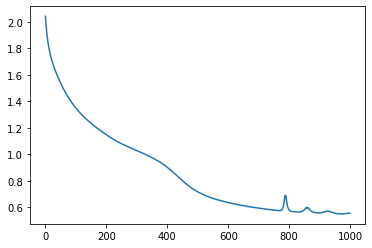

In [173]:
# Loss for epoches = 1000 with WRAP
plt.plot(np.arange(epochs), loss)

In [175]:
min(loss)

<tf.Tensor: shape=(), dtype=float32, numpy=0.5493672>

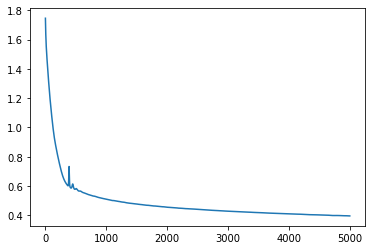

In [183]:
# Loss for epoches = 5000 with WRAP
plt.plot(np.arange(epochs), loss)

In [184]:
min(loss)

<tf.Tensor: shape=(), dtype=float32, numpy=0.39504564>

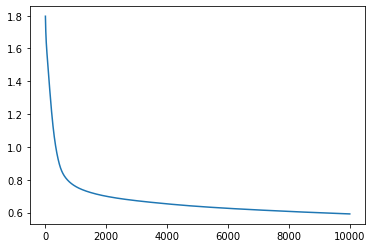

In [ ]:
# Loss for epoches = 10000
plt.plot(np.arange(epochs), loss)

In [ ]:
min(loss)

<tf.Tensor: shape=(), dtype=float32, numpy=0.59180063>

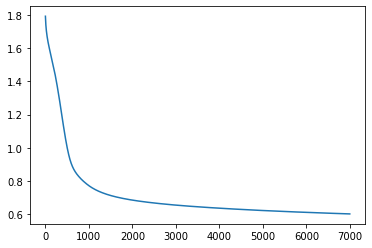

In [ ]:
# Loss for epoches = 7000
plt.plot(np.arange(epochs), loss)

In [ ]:
min(loss)

<tf.Tensor: shape=(), dtype=float32, numpy=0.6017213>

In [ ]:
max(loss)

<tf.Tensor: shape=(), dtype=float32, numpy=1.7929125>

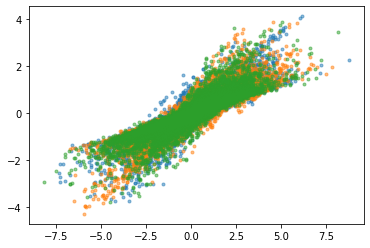

In [ ]:
for d in range(3):
    plt.plot(f[::, d], fb[::, d], '.', alpha=0.5)


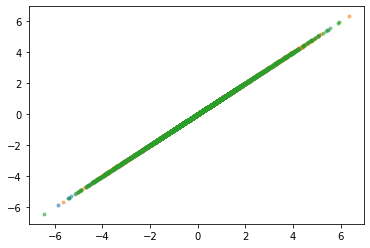

In [ ]:
for d in range(3):
    plt.plot(fb[::, d], fb[::, d], '.', alpha=0.5)

In [ ]:
for d in range(3):
    print(np.corrcoef(fb[:, d], fb[:, d]))

[[1. 1.]
 [1. 1.]]
[[1. 1.]
 [1. 1.]]
[[1. 1.]
 [1. 1.]]


In [186]:
out = tf.squeeze(o)
out.shape

TensorShape([32768, 3])

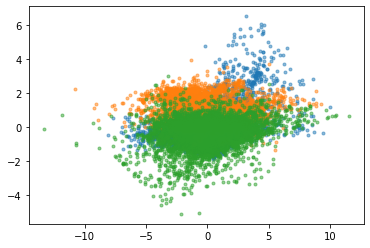

In [179]:
## After training for 1000 epoches with Wrap
for d in range(3):
  plt.plot(y[::, d],out[::,d],'.', alpha=0.5)

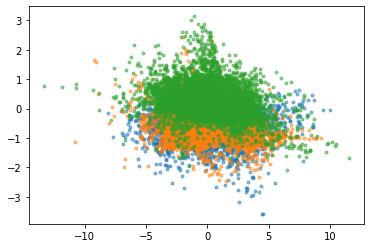

In [187]:
## After training for 5000 epoches with Wrap
for d in range(3):
  plt.plot(y[::, d],out[::,d],'.', alpha=0.5)

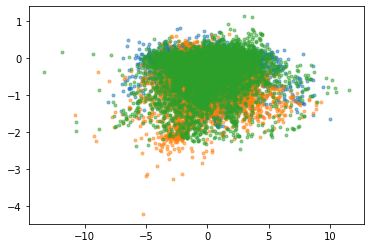

In [ ]:
## After training for 5000 epoches
for d in range(3):
  plt.plot(y[::, d],out[::,d],'.', alpha=0.5)

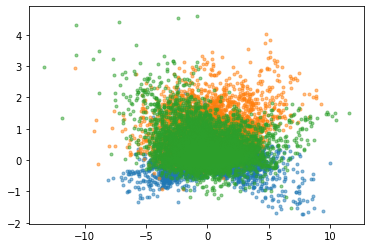

In [ ]:
## After training for 7000 epoches
for d in range(3):
  plt.plot(y[::, d],out[::,d],'.', alpha=0.5)

In [ ]:
for d in range(3):
    print(np.corrcoef(y[:, d], out[:, d]))

[[1.         0.04495316]
 [0.04495316 1.        ]]
[[1.         0.19383837]
 [0.19383837 1.        ]]
[[ 1.         -0.05820651]
 [-0.05820651  1.        ]]


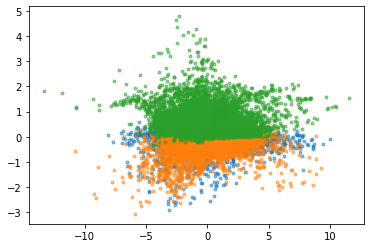

In [ ]:
## After training for 10000 epoches
for d in range(3):
  plt.plot(y[::, d],out[::,d],'.', alpha=0.5)

In [ ]:
for d in range(3):
    print(np.corrcoef(y[:, d], out[:, d]))

[[1.         0.04495316]
 [0.04495316 1.        ]]
[[1.         0.19383837]
 [0.19383837 1.        ]]
[[ 1.         -0.05820651]
 [-0.05820651  1.        ]]


In [ ]:
plt.plot(fin[::,], fb[::, d], '.', alpha=0.5)

In [ ]:
np.pad(ip_m,1 , mode='wrap').shape

(3, 34, 34, 34, 3)

In [ ]:
aaa= np.pad(ip_m,1 , mode='wrap')
aaa.shape

(3, 34, 34, 34, 3)

In [145]:
m = tf.constant([[[1, 3],[3, 2]],[[7, 0],[9, 5]]])
m

<tf.Tensor: shape=(2, 2, 2), dtype=int32, numpy=
array([[[1, 3],
        [3, 2]],

       [[7, 0],
        [9, 5]]], dtype=int32)>

In [135]:
m1=np.pad(m,((0,0),(1,1),(1,1)),mode='wrap')
m1

array([[[3, 1, 3, 1],
        [3, 1, 3, 1],
        [3, 1, 3, 1]],

       [[2, 3, 2, 3],
        [2, 3, 2, 3],
        [2, 3, 2, 3]]], dtype=int32)

In [136]:
m1.shape

(2, 3, 4)